In [1]:
using Random, PyPlot, LinearAlgebra, Statistics, DataFrames, FITSIO, FITSTables, CSV, PyCall, JLD2

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/aw/.julia/packages/PyPlot/4wzW1/src/init.jl:192


In [2]:
include("get_lamost_spectra.jl")
LogNorm = pyimport("matplotlib.colors").LogNorm
include("../cats/human_readable_names.jl")
include("figures.jl")
include("model.jl")
;

# prep data

In [7]:
wl_grid = load("wl_grid.jld2")["wl_grid"];

In [33]:
Random.seed!(0)
ntest = 1000
test_obsids = rand(FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr4v2-stellar.fits.gz").obsid, ntest);

In [34]:
download_lamost_spectra(test_obsids);
test_spectra = []
test_ivar = []
for obsid in test_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid)
    push!(test_spectra, flux)
    push!(test_ivar, ivar)
end

;

of 1000 spectra, 0 need to be downloaded


In [35]:
include("get_lamost_spectra.jl")
rf_obsids = CSV.read("./random.csv").obsid;
download_lamost_spectra(rf_obsids)

rf_spectra = []
rf_ivar = []
for obsid in rf_obsids
    wl, flux, ivar = load_lamost_spectrum(obsid)
    push!(rf_spectra, flux)
    push!(rf_ivar, ivar)
end
rf_spectra = transpose(reduce(hcat, rf_spectra))
rf_ivar = transpose(reduce(hcat, rf_ivar))
;

of 1000 spectra, 0 need to be downloaded


In [36]:
#remove blue end of spectrum
#test_spectra = [s[500:end] for s in test_spectra]
#test_ivar = [v[500:end] for v in test_ivar]
#rf_spectra = rf_spectra[:, 500:end]
#;

In [37]:
#whiten spectra
#typical_uncertainty = [mean(col[col .!= 0.0].^(-1/2)) for col in eachcol(rf_ivar)];
#plot(wl_grid, typical_uncertainty)
#
#rf_spectra .-= 1
#rf_spectra ./= typical_uncertainty'
#rf_ivar .*= typical_uncertainty'.^2
#test_spectra = [(f .- 1)./typical_uncertainty for f in test_spectra]
#test_ivar = [iv .* typical_uncertainty.^2 for iv in test_ivar]
#;

# compare old and new methods

In [ ]:
include("model.jl")

maskfrac = 0.1
k = 10
q = 5

rf_set = rf_spectra

f, ivar = rand(collect(zip(test_spectra, test_ivar)))
mask = rand(size(rf_spectra, 2)) .< maskfrac

neighbors = find_neighbors(f[.! mask], ivar[.! mask].^(-5f-1), rf_spectra[:, .! mask]', (Inf .+ rf_ivar[:, .! mask])'.^(-5f-1), k)
F = rf_spectra[neighbors, :]

pf = project_onto_local_manifold(F, f, ivar, mask, q)
println(mean((pf[mask] - f[mask]).^2 .* ivar[mask]))

figure(figsize=(12, 4))
pltmask = 1750:1850
#plot(f[pltmask],  label="data")
errorbar(pltmask .- pltmask[1], f[pltmask], yerr=ivar[pltmask].^(-1/2))
plot(pf[pltmask], label="PCs")
plot(F[:, pltmask]', c="k", alpha=0.2)
#for spec in 
#    plot(spec[pltmask], c="k", alpha=0.1)
#end

include("model.jl")
μ = mean(F, dims=1)
FF = Matrix((F .- μ)')[:, 1:end-1]
w = calculate_weights(FF, Float32.(f .- μ[:]), Float32.(ivar.^(-5f-1)))
plot((FF*w + μ[:])[pltmask], label="neighbors")
legend()

#
#figure(figsize=(12, 3))
#title("old model is reproduced exactly")
#diff = (FF * w + μ[:] - pf) 
#plot(diff, label="q = 5")
#println(sum(diff.^2))
#pf = project_onto_local_manifold(F, f, ivar, mask, k-1)
#diff = (FF * w + μ[:] - pf) 
#plot(diff, label="q = k-1")
#println(sum(diff.^2))
#legend()

# parameter study

In [14]:
function MSE(rf_spectra, test_spectra, test_ivar, k, q; maskfrac = 0.1)
    Random.seed!(2)
    
    MSE = map((zip(test_spectra, test_ivar))) do (f, ivar)
        masksize = 100
        npix = size(rf_spectra, 2)
        ind = rand(1 : npix-100)
        mask = ind .<= (1:npix) .<= ind + 100
        
        dists = map(eachrow(rf_spectra)) do rf_spec                                                  
            sum((f[.! mask] .- rf_spec[.! mask]).^2 .* ivar[.! mask])
        end 
        F = rf_spectra[partialsortperm(dists, 1:k), :] 
        #pf = project_onto_local_manifold((F .- 1)./ typical_uncertainty', 
        #    (f .- 1) ./typical_uncertainty, ivar .* typical_uncertainty.^2,
        #     mask, q) .* typical_uncertainty .+ 1
        pf = project_onto_local_manifold(F, f, ivar, mask, q)
        
        #figure(figsize=(12, 4))
        #errorbar(wl_grid[mask], f[mask], yerr=ivar[mask].^(-1/2))
        #plot(wl_grid[mask],pf[mask])
        #plot(wl_grid[mask],F[:, mask]', c="k", alpha=0.1)
        #figure(figsize=(12, 3))
        #plot(wl_grid,f)
        #plot(wl_grid,pf)
        #plot(wl_grid,F', c="k", alpha=0.1)
        
        mean((pf[mask] - f[mask]).^2 .* ivar[mask])
    end
    mean(MSE)
end
@time MSE(rf_spectra, test_spectra, test_ivar, 10, 5)

234.578278 seconds (22.77 M allocations: 182.654 GiB, 8.71% gc time)


1.184982102145747

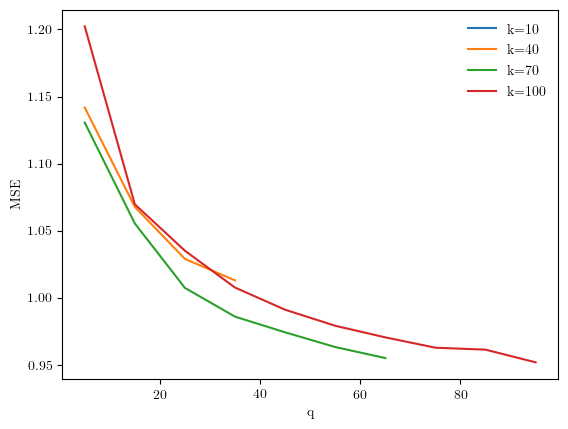

1384.547333 seconds (398.36 M allocations: 2.230 TiB, 16.58% gc time)


PyObject <matplotlib.legend.Legend object at 0x1408e9fd0>

In [307]:
@time for k in 10:30:120
    qs = collect(5:10:k-1)
    MSEs = [MSE(rf_spectra, test_spectra, test_ivar, k, q) for q in qs]
    plot(qs, MSEs, label="k=$k")
end
xlabel("q")
ylabel("MSE")
legend()

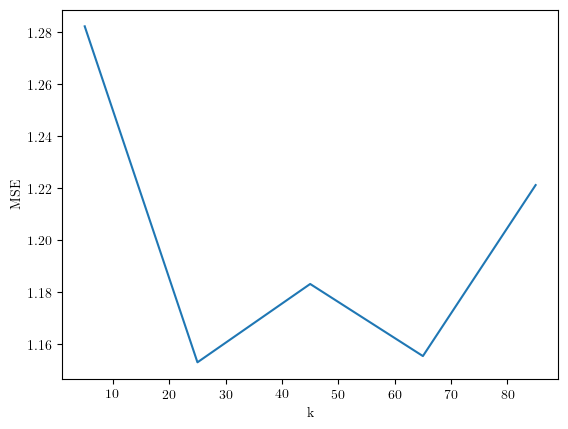

1127.884584 seconds (105.92 M allocations: 919.731 GiB, 10.60% gc time)


PyObject Text(22.299550986642977, 0.5, 'MSE')

In [15]:
q = 4
ks = 5:20:100
@time MSEs = map(ks) do k
    MSE(rf_spectra, test_spectra, test_ivar, k, q)
end
plot(ks, MSEs) 
xlabel("k")
ylabel("MSE")

# test Li outliers with large $k, q$

In [7]:
using CSV
outliers = CSV.read("distributed_topsnr_1000_test.flagged.csv");

In [124]:
download_lamost_spectra(outliers.obsid)

outlier_spectra = []
outlier_ivar = []
for obsid in outliers.obsid
    wl, flux, ivar = load_lamost_spectrum(obsid; clip=false)
    push!(outlier_spectra, flux)
    push!(outlier_ivar, ivar)
end
;

of 760 spectra, 0 need to be downloaded


In [228]:
wl_grid = load("wl_grid.jld2")["wl_grid"]
Δλ = 7
li_air = 6707.85
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ;

In [276]:
include("model.jl");

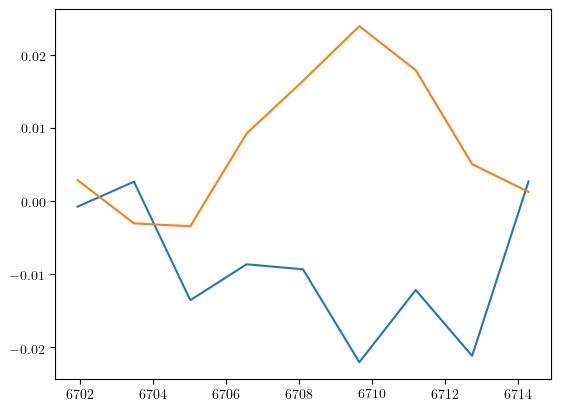

[154204108, 321609186, 156803144, 214008018, 173103134, 160114155]
[181709187, 291415040, 421404044, 274608148, 363911217, 387710043]
(6, 3559)


In [277]:
k, q = 6, 5

ind = rand(1:length(outlier_spectra))
f = test_spectra[ind]
ivar = test_ivar[ind]

neighbors = find_neighbors(f[.! line_mask], 
    ivar[.! line_mask].^(-5f-1), 
    rf_spectra[:, .! line_mask]', 
    rf_ivar[:, .! line_mask]'.^(-5f-1), k)
#dists = map(zip(eachrow(rf_spectra), eachrow(rf_ivar)) do (rf_spec, rfivar)
#    sum((f[.! line_mask] .- rf_spec[.! line_mask]).^2 .* ivar[.! line_mask])
#end 
println(rf_obsids[neighbors])
println(outliers.neighbors[ind])
F = rf_spectra[neighbors, :]
println(size(F))

pf = project_onto_local_manifold(F, f, ivar, line_mask, q)

w = calculate_weights(Matrix(F[:, .! line_mask]'), f[.! line_mask], ivar[.! line_mask].^(-5f-1))

figure()
plot(wl_grid[line_mask], F[:, line_mask]' * w - f[line_mask])
#plot(f[line_mask])
diff = eval(Meta.parse(outliers.diff[ind]))
plt.plot(wl_grid[line_mask], diff)

#println(outliers.diff[ind])
#ylim(-0.1, 0.1)
#yticks(-0.1 : 0.05 : 0.1)

#figure(figsize=(12, 4))
#plot(wl_grid, f, label = "data")
#plot(wl_grid, pf, label="projected spectrum")
#plot(wl_grid, F', c="k", alpha=0.1)
#axvline(6709.7)
#xlim(6670, 6750)
#axvspan(li_air-10, li_air+10, color="grey", alpha=0.3)
#ylim(0.9, 1.06)
#legend()
#
#figure(figsize=(12, 4))
#plot(wl_grid, f, label = "data")
#plot(wl_grid, pf, label="projected spectrum")
#plot(wl_grid, F', c="k", alpha=0.1)
#;